In [1]:
#Add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

# CDD-CESM



This dataset is an Egyptian dataset composed of 2006 images IN TOTAL, composed of low-energy and constrast-enhanced spectral mamography, aka dual energy.

- 1003 low-energy images
- 1003 CESM

The number of patients is 326. Usually one patient has 8 images:
- 4 images per modality
    - 2 lateralities (L, R) and 2 views (CC, MLO)

Nevertheless, there are some exceptions so the number of total images is not the total hypothetic maximum 2068.

Besides the images we have:
- ROI of the findings: coordinates of the geometrical figure (ellipse, poligon, etc.)
- Biopsy results: benign, malignant.
- finding type: mass, asymmetry, 

## Can CCD-CESM be combined with the INCan DE dataset?
The project should be able to go by itself (no need of additional dataset) but it could be a nice addition to have another underrepresented population (mexican) in the study.

### Similarities
- Both dataset are, in theory, from the <u> same clincial protocol</u>, so it should be possible.
- Both datasets contain handmade ROI segmentations of the findings.
    - Which findings?
- Both dataset seem to have the presubstraction images UNREGISTERED.
    - Important to kepe in mind when using the ROI coordinates.

# Differences
- The mexican dataset have the raw images available, so all the original pixel intensities are available. The egyptian dataset has the images already preprocessed to 8bits.
- The egyptian dataset has black background, therefore has send the negative pixel intensities into a special value (zero?), or map inverselly towards 255. In any case, the images seem to be only showing the contrast-uptake, which is essential for detection.

In [2]:
import cv2 as cv
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import pandas as pd
import ast
import numpy as np

# Annotations

- We have annotations for basically all patients,and both modalities!<br>
    It is important to remember that not all annotations are from masses so probably the number of images to be used will be less than the total number of images...

In [105]:
class dataset_CDD_CESM:
    """Class to load the CDD-CESM dataset
    """
    def __init__(self) -> None:
        # useful items
        self.alias = {'low-energy':'DM', 'substracted':'CESM'}
        # paths
        self.im_dir = repo_path / 'data/CDD-CESM/images'
        # self.im_dir = 'data/CDD-CESM/images'
        self.metadata_path = repo_path / 'data/CDD-CESM/metadata/Radiology_manual_annotations.xlsx'
        self.annotations_path = repo_path / 'data/CDD-CESM/metadata/Radiology_hand_drawn_segmentations_v2.csv'
        # read metadata
        self.metadata = pd.read_excel(self.metadata_path, sheet_name='all')
        self.annotations = pd.read_csv(self.annotations_path, converters={'region_shape_attributes':ast.literal_eval}) # read region_shape_attributes as a dictionary
        # attributes
        self.patient_ids = self.metadata['Patient_ID'].unique()
    def __repr__(self) -> str:
        return f'CDD-CESM dataset with {len(self.patient_ids)} patients\nTotal images: {len(self.metadata)}, half low-energy, half dual-energy'
    
    def get_images_paths(self, mode='low-energy' or 'substracted', metadata = None):
        """given the metadata given all paths will be returned

        Args:
            mode (str, optional): dual energy protocol modality. Defaults to 'low-energy'or'substracted'.
            metadata (pd.DataFrame, optional): if not given, object metadata is used. Defaults to None.

        Raises:
            ValueError: if mode is not valid

        Returns:
            pd.Series: series with the paths of the images
        """

        if metadata is None: # if no input is given, use the class attribute
            metadata = self.metadata

        if mode not in self.alias.keys():
            raise ValueError(f'Invalid mode. Use one of {self.alias.keys()}')
        
        mode_metadata = metadata[metadata.Type == self.alias[mode]].reset_index(drop=True)
        
        dm_images = str(self.im_dir) + f'/{mode}/' + mode_metadata.Image_name + '.jpg'

        return dm_images

class patient_CDD(dataset_CDD_CESM):
    def __init__(self, patient_id:int, dataset = dataset_CDD_CESM()) -> None:
        super().__init__()
        self.patient_id = patient_id
        self.metadata = dataset.metadata[dataset.metadata.Patient_ID == patient_id].reset_index(drop=True)
        # individual instantaneus attributes
        self.image_lat = None
        self.image_view = None
        self.image_mode = None
    def __repr__(self) -> str:
        return f'Patient {self.patient_id} with {len(self.metadata)} images (half low-energy, half dual-energy)'
    
    def set_image(self, view:str = 'CC' or 'MLO', mode:str = 'low-energy' or 'substracted', laterality:str = 'L' or 'R'):
        """set the image to be used. An image is fully defined if the three inputs are given
        further information can be extracted after setting the image

        Args:
            view (str, optional): image view of the mamomgram. Defaults to 'CC'or'MLO'.
            mode (str, optional): modality of the dual-energy protocol. Defaults to 'low-energy'or'substracted'.
            laterality (str, optional): side or laterality. Defaults to 'L'or'R'.
        """
        # check inputs
        if view not in ['CC', 'MLO']:
            raise ValueError('Invalid view. Use CC or MLO')
        if mode not in self.alias.keys():
            raise ValueError(f'Invalid mode. Use one of {self.alias.keys()}')
        if laterality not in ['L', 'R']:
            raise ValueError('Invalid laterality. Use L or R')
        
        # filter based on the inputs
        self.image_metadata = self.metadata[(self.metadata.View == view)
                                           & (self.metadata.Type == self.alias[mode])
                                           & (self.metadata.Side == laterality)].reset_index(drop=True)
        
        # if no image is found, raise error
        if len(self.image_metadata) == 0:
            print(f'Possible values:\n{self.metadata.Image_name}')
            raise FileNotFoundError('No image found with the given parameters')
        
        self.image_lat = laterality
        self.image_view = view
        self.image_mode = mode
        self.image_path = self.get_path()
        self.image_findings = self.image_metadata['Findings'].values[0]
        self.image_tags = self.image_metadata['Tags'].values[0]
        self.image_annotations = self.annotations[self.annotations['#filename'] == self.image_path.name].reset_index(drop=True)
        self.image_num_annotations = len(self.image_annotations)

    def get_path(self):
        """get path of defined image

        Returns:
            str: path of the image, defined by get_images_paths
        """
        paths_series = self.get_images_paths(self.image_mode, self.image_metadata)
        if len(paths_series) > 1:
            raise ValueError('More than one image found')
        elif len(paths_series) == 0:
            raise FileNotFoundError('No image found')
            
        
        return Path(paths_series[0])
    
    
    def get_array(self, flip:bool = False, plot:bool = False):
        """get the array of the set image previously defined

        Args:
            flip (bool, optional): if to flip the right lateral images ot the left. Defaults to False.
            plot (bool, optional): plot or not to see the image fast. Defaults to False.

        Raises:
            FileNotFoundError: if the image is not found

        Returns:
            np.array: image as a numpy array
        """
        # check if path exists
        if not os.path.exists(self.image_path):
            raise FileNotFoundError(f'Image not found at {self.image_path}')
        
        # read the image
        image = cv.imread(str(self.image_path))
        if flip and self.image_lat == 'R':
            image = cv.flip(image, 1)
        
        if plot:
            plt.imshow(image)
            plt.axis('off')
            plt.show()
        
        return image
    
    def ellipse_reader(self, annot:dict):
        """read the coordinates of a ellipse-like ROI

        Args:
            annot (dict): _description_

        Raises:
            ValueError: _description_

        Returns:
            _type_: _description_
        """
        if annot['name']=='ellipse':
            center = (annot['cx'], annot['cy'])
            semiaxes = (annot['rx'], annot['ry'])
        elif annot['name']=='circle':
            center = (annot['cx'], annot['cy'])
            semiaxes = (annot['r'], annot['r'])
        else:
            raise ValueError('wring reader')

        return center, semiaxes
    
    def polygon_reader(self, annot:dict):
        """read the coordinates of a polygon-like ROI

        Args:
            annot (dict): annotations

        Raises:
            ValueError: if the reader is not correct
        """
        if annot['name']!='polygon':
            raise ValueError('wrong reader')
        vertices = annot['all_points_x'], annot['all_points_y']
        vertices = np.array(vertices).T

        return vertices
    
    def point_reader(self, annot:dict):
        """read the coordinates of a point-like ROI

        Args:
            annot (dict): annotations

        Raises:
            ValueError: if the reader is not correct
        """
        if annot['name']!='point':
            raise ValueError('wrong reader')
        center = (annot['cx'], annot['cy'])

        return center
    
    def plot_annotations(self, flip:bool = False):
        image = self.get_array(flip=False, plot=False)
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        ax.imshow(image)
        ax.set_title(f'Pat_{self.image_path.stem}, findings: {self.image_findings}\n{self.image_num_annotations} regions')
        for region_num in range(self.image_num_annotations):
            dic_ex = self.image_annotations[self.image_annotations.region_id==region_num].region_shape_attributes.values[0]
            # plot annotation
            if dic_ex['name'] in ['ellipse','circle']:
                center, axes = self.ellipse_reader(dic_ex)
                ax.add_patch(Ellipse(center, 2*axes[0], 2*axes[1], fill=False, edgecolor='r'))
            elif dic_ex['name']=='polygon':
                vertices = self.polygon_reader(dic_ex)
                ax.plot(vertices[:,0], vertices[:,1], 'r')
            elif dic_ex['name']=='point':
                center = self.point_reader(dic_ex)
                ax.scatter(center[0], center[1], c='r', s=10)
            fig.tight_layout()
        plt.show()

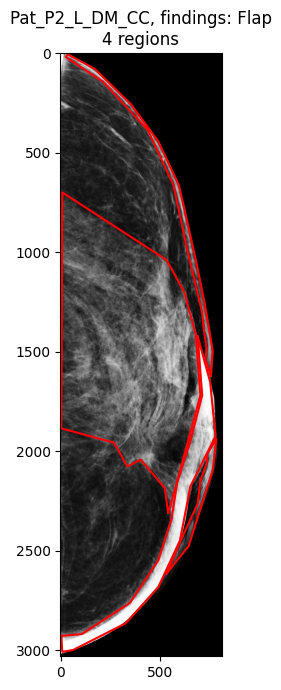

In [109]:
dataset = dataset_CDD_CESM()
pat_example = patient_CDD(patient_id=2, dataset=dataset)

view = 'CC'
mode = 'low-energy'
laterality = 'L'

pat_example.set_image(view=view, mode=mode, laterality=laterality)
image = pat_example.get_array(flip=False, plot=False)
pat_example.plot_annotations(flip=False)

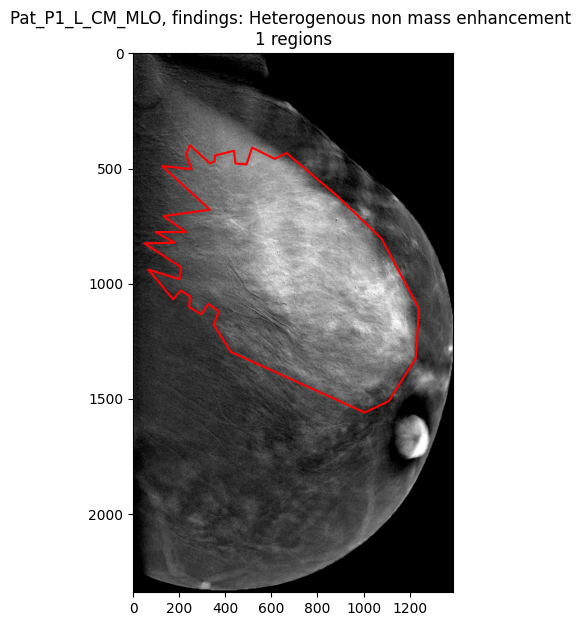

In [103]:
fig, ax = plt.subplots(1,1, figsize=(14,7))
ax.imshow(image)
ax.set_title(f'Pat_{pat_example.image_path.stem}, findings: {pat_example.image_findings}\n{pat_example.image_num_annotations} regions')
for region_num in range(pat_example.image_num_annotations):
    dic_ex = pat_example.image_annotations[pat_example.image_annotations.region_id==region_num].region_shape_attributes.values[0]
    # plot annotation
    if dic_ex['name'] in ['ellipse','circle']:
        center, axes = pat_example.ellipse_reader(dic_ex)
        ax.add_patch(Ellipse(center, 2*axes[0], 2*axes[1], fill=False, edgecolor='r'))
    elif dic_ex['name']=='polygon':
        vertices = pat_example.polygon_reader(dic_ex)
        ax.plot(vertices[:,0], vertices[:,1], 'r')
    elif dic_ex['name']=='point':
        center = pat_example.point_reader(dic_ex)
        ax.scatter(center[0], center[1], c='r', s=10)